In [8]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [46]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    # data = (data - data.mean(axis=0)) / data.std(axis=0)
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [47]:
def custom_sgd(params, grads, hyperparams):
    for param, grad in zip(params, grads):
        param.assign_sub(hyperparams['lr']*grad)

In [48]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=2):
    # Initialization
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1,
            kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    # optimizer = trainer_fn(**hyperparams)
    loss = tf.keras.losses.MeanSquaredError()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out)
                params = net.trainable_variables
                grads = g.gradient(l, params)
            # optimizer.apply_gradients(zip(grads, params))
            trainer_fn(params, grads, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                p = n/X.shape[0]
                q = p/tf.data.experimental.cardinality(data_iter).numpy()
                # `MeanSquaredError` computes squared error without the 1/2
                # factor
                r = (d2l.evaluate_loss(net, data_iter, loss) / 2,)
                animator.add(q, r)
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

In [49]:
def logistic_regression():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
    return model

In [50]:
def linear_regression():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 1, activation = None))
    return model

In [51]:
class sgd:
    def __init__(self, hyperparams):
        self.lr = hyperparams['lr']

    def apply_gradients(self, zipped):
        for grad, param in zipped:
            param.assign_sub(self.lr*grad)

In [52]:
def general_trainer(model, data_iter, loss, optimizer, hyperparams, epochs):
    
    network = model()
    optimizer = optimizer(hyperparams)
    loss = loss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, epochs])
    n, timer = 0, d2l.Timer()
    for _ in range(0, epochs):
        for X, y in data_iter:
            with tf.GradientTape() as g:
                out = network(X)
                l = loss(y, out)
                params = network.trainable_variables
                grads = g.gradient(l, params)

            optimizer.apply_gradients(zip(grads, params))
            # trainer_fn(params, grads, hyperparams)
            n += X.shape[0]
            if n % 100 == 0:
                timer.stop()
                p = n/X.shape[0]
                q = p/tf.data.experimental.cardinality(data_iter).numpy()
                # `MeanSquaredError` computes squared error without the 1/2
                # factor
                r = (d2l.evaluate_loss(network, data_iter, loss) / 2,)
                animator.add(q, r)
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 8042.672, 0.028 sec/epoch


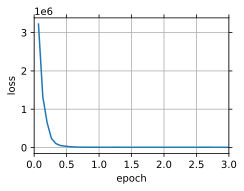

In [54]:
data_iter, _ = get_data_ch11(10)
general_trainer(linear_regression, data_iter, tf.keras.losses.MeanSquaredError, sgd, {'lr': 1e-9}, 3)

loss: nan, 0.056 sec/epoch


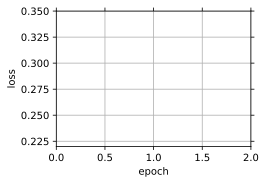

In [45]:
data_iter, _ = get_data_ch11(10)
# trainer = tf.keras.optimizers.SGD
train_concise_ch11(custom_sgd, {'lr': 0.05}, data_iter)